# INM702
## Task 2
#### Developing a multi-layer neural network for classification of the MNIST dataset

#### Importing libraries:

In [220]:
import numpy as np
from numpy.random import default_rng
import time

import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import itertools
import os

#### Define path to export figures and results:

In [221]:
path = "C:\\Task2 Results"

### Implementation of a Neural network
#####  The implementation of the neural network consists of the below:
- Data Class to scale the data and get the batches with specified batch size
- ActivationFunction classes for the different activations we need in the neural network: Sigmoid,ReLu and SoftMax
- CrossEntropyLoss class to compute the loss of model and the gradient of the loss during the training stage
- Optimizer class that implements a classic optimizer with fixed learning rate and Adam optimizer based
- NeuralNetworkLayer class that represents the different layers of the network
- NeuralNetwork class, the main class that allows for different architectures of neural network and support training and prediction based on different data



In [2]:
class Data:
    # A class that will put the data in the correct format to be used by Neural Network
    # The raw targets based on labels are tranformed to a vector: if a raw target is 7 it will be transfromed to
    # [0,0,0,0,0,0,0,1,0,0] 
    # The raw inputs that are matrices are flattened to vectors
    # If a scaler is a provided the data is scaled
    # get_data_with_batches method allows us to shuffle the data if the suffling was selected and
    # get a split of the data into mini batches 
    def __init__(self,raw_inputs,raw_targets,labels,seed=0):
        
        self.raw_inputs  = raw_inputs
        self.raw_targets = raw_targets
        
        self.transformed_inputs  = None
        
        self.labels      = labels
        self.data_scaler = None
        self.seed        = seed
        self.rng         = default_rng(seed)
        self.reset()
        
    def reset(self):
       
        self.transformed_inputs  = self.raw_inputs  if(self.data_scaler is None) else self.data_scaler.transform(self.raw_inputs)
          
        self.inputs  = self.transformed_inputs.reshape(self.transformed_inputs.shape[0],-1)        
        self.targets = np.zeros((self.raw_targets.shape[0],len(self.labels)))    
        for idx in range(self.raw_targets.shape[0]):self.targets[idx,self.labels.index(self.raw_targets[idx])]=1 
        
        self.rng     = default_rng(self.seed)
        return 
    
    def set_data_scaler(self,data_scaler):
        self.data_scaler = data_scaler
        self.reset()
        return
    def remove_data_scaler(self):
        self.data_scaler = None
        self.reset()
        return
    def get_data_with_batches(self,batch_size=None,shuffle=False):
        if(batch_size is None):
            return [self.inputs],[self.targets]
        else:
            aggr = np.concatenate((self.inputs,self.targets),axis=1)
            if(shuffle):
                self.rng.shuffle(aggr)
                
            X_batches = []
            y_batches = []

            for idx in range(0,self.inputs.shape[0],batch_size):
                X_batches += [aggr[idx:idx+batch_size,:self.inputs.shape[1]]]
                y_batches += [aggr[idx:idx+batch_size,self.inputs.shape[1]:]]

            return X_batches,y_batches

In [3]:
class SimpleDataScaler:
    # A sclar that that scales the data based on the min and max values of the data used in the initialization
    # the new range of the sacaled data will be between 0 and 1
    def __init__(self,data):
        self.max  = np.max(data)
        self.min  = np.min(data)
        
    def transform(self,data):
        return (data - self.min)/self.max

In [219]:
class ActivationFunctionFactory:
    # a factory class that allows us to get the activation function object 
    # from the activation function name at neural network layer
    def get_activation_function(self,activation_function_name):
        if(activation_function_name=='Linear'):
            return LinearActivationFunction()
        elif (activation_function_name=='ReLu'):
            return ReLuActivationFunction()
        elif (activation_function_name=='Sigmoid'):
            return SigmoidActivationFunction()
        elif(activation_function_name=='SoftMax'):
            return SoftMaxActivationFunction()
        else:
            print(activation_function_name)
            raise ValueError("ActivationFunctionFactory.get_activation_function:Activation function name not recognized")
    
class ActivationFunction:
    # a mother class that provides and interface for the activation function, 
    # all activation functions need to support valuation and gradient calculation as methods
    # the gradient method returns the gradient of output of the network (cross entropy loss) wrt to the input vector
    # it takes as input the input vector needed to value the function and the gradient of output of
    # network (loss) wrt the outputs of the activation function. 
    def get_value(self,input_vector):
        return
    def get_gradient(self,input_vector,output_gradient):
        return

class LinearActivationFunction(ActivationFunction):
    def get_value(self,input_vector):
        return input_vector
    def get_gradient(self,input_vector,output_gradient):
        return output_gradient

class ReLuActivationFunction(ActivationFunction):
    def get_value(self,input_vector):
        return np.maximum(0,input_vector)
    def get_gradient(self,input_vector,output_gradient):
        return np.ones(input_vector.shape)*(input_vector>=0)*output_gradient

#Both inputs for both Sigmoid and SoftMax are clipped to avoid overflow
class SigmoidActivationFunction(ActivationFunction):
    def get_value(self,input_vector):
        return (1/(1+np.exp(-np.clip(input_vector,-25,25))))
    def get_gradient(self,input_vector,output_gradient):
        return  self.get_value(input_vector)*(1-self.get_value(input_vector))*output_gradient

class SoftMaxActivationFunction(ActivationFunction):
    def get_value(self,input_vector):
        exp_vector = np.exp(np.clip(input_vector,-25,25))
        return exp_vector/np.sum(exp_vector,axis=1,keepdims=True)

    def get_gradient(self,input_vector,output_gradient):
        res = self.get_value(input_vector)
        soft_max_gradient = np.empty_like(output_gradient)
        for index in range(input_vector.shape[0]):
            reshape_res = res[index].reshape(1,res[index].shape[0])
            jacobian_matrix    = -np.dot(reshape_res.T,reshape_res) + np.diagflat(reshape_res)
            soft_max_gradient[index] = np.dot(output_gradient[index],jacobian_matrix)
        return np.array(soft_max_gradient)

In [266]:
#A class for the Cross entropy loss, this class is different from the above class of activation function as get_value 
# and get_gradient uses different inputs. 
class CrossEntropyLoss:
    def __init__(self,min_proba):
        self.min_proba = min_proba if (min_proba is not None) else 1e-10
        
    def get_value(self,predicted,actual):
        
        if predicted.shape[1]==1:
            processed_actual = actual.reshape(actual.shape[0],1)
            return -np.log(np.clip(predicted,self.min_proba,1-self.min_proba))*processed_actual-np.log(np.clip(1-predicted,self.min_proba,1-self.min_proba))*(1-processed_actual) 
        else:
            return -np.sum(np.log(np.clip(predicted,self.min_proba,1-self.min_proba))*actual,axis=1,keepdims=True)
    def get_gradient(self,predicted,actual):#the gradient wrt to predicted data
         
        if predicted.shape[1]==1:
            processed_actual = actual.reshape(actual.shape[0],1)   
            return -processed_actual/(np.clip(predicted,self.min_proba,1-self.min_proba))+(1-processed_actual)/(np.clip(1-predicted,self.min_proba,1-self.min_proba))
        else:
            return -actual/(np.clip(predicted,self.min_proba,1-self.min_proba))

In [265]:
class Optimizer:
    #class for the optimizer 
    #this class will store the information about the history of the optimization,decides when the process of 
    #the optimization should be stopped and update the weight and biases of the layers based on the learning rate 
    
    def __init__(self,max_epochs,target_precision,learning_rate):
        self.max_epochs        = max_epochs
        self.n_iteration       = 0 #number of iteration for mini batches and SGD
        self.target_precision  = target_precision
        self.learning_rate     = learning_rate
        
        self.historical_loss     = {'train':[],'validate':[]}
        self.historical_accuracy = {'train':[],'validate':[]}
        
    def reset(self):
        
        self.n_iteration = 0
        
        self.historical_loss['train']    = []
        self.historical_loss['validate'] = []
        
        self.historical_accuracy['train']    = []
        self.historical_accuracy['validate'] = []
        
        return
  
    def update_layers(self,nn_layers):
     
        for layer in nn_layers:
            layer.weights -= self.learning_rate*layer.delta_weights
            layer.biases  -= self.learning_rate*layer.delta_biases
        return
    
    def optimize(self):        
        n_epochs = len(self.historical_loss['train'])        
        return n_epochs<self.max_epochs
         
    
    def get_loss_accuracy(self):
        return self.historical_loss,self.historical_accuracy

In [264]:
class AdamOptimizer(Optimizer):
    # Implementation of the Adam optimizaion method, this class inherits from the Optimizer above
    # The update of the weights and biases is done based on the momentum and variance of the gradient as described
    # in the adam forumula. the m_t and v_ dectionaries will store the expected gradient and variance of the gradient 
    # for the different layers and different weights and biases
    def __init__(self,max_epochs,target_precision,learning_rate,beta_1,beta_2,epsilon):
        super().__init__(max_epochs,target_precision,learning_rate)
        self.beta_1  = beta_1
        self.beta_2  = beta_2
        self.epsilon = epsilon
        self.m_t     = {}
        self.v_t     = {}
    
    def rest(self):
        super().rest()
        self.m_t     =  {}
        self.v_t     =  {}
        return
    
    def update_layers(self,nn_layers):
        
        self.n_iteration += 1
        
        if(self.m_t == {}):
            for layer in nn_layers:
                self.m_t[layer.name]={}
                self.m_t[layer.name]['m_weight'] = np.zeros(layer.delta_weights.shape)
                self.m_t[layer.name]['m_biases'] = np.zeros(layer.delta_biases.shape)
        
        if(self.v_t == {}):
            for layer in nn_layers:
                self.v_t[layer.name]={}
                self.v_t[layer.name]['v_weight'] = np.zeros(layer.delta_weights.shape)
                self.v_t[layer.name]['v_biases'] = np.zeros(layer.delta_biases.shape)
        
            
        for layer in nn_layers:
            self.m_t[layer.name]['m_weight'] = self.beta_1*self.m_t[layer.name]['m_weight']+(1-self.beta_1)*layer.delta_weights
            self.m_t[layer.name]['m_biases'] = self.beta_1*self.m_t[layer.name]['m_biases']+(1-self.beta_1)*layer.delta_biases
            
            self.v_t[layer.name]['v_weight'] = self.beta_2*self.v_t[layer.name]['v_weight']+(1-self.beta_2)*layer.delta_weights**2
            self.v_t[layer.name]['v_biases'] = self.beta_2*self.v_t[layer.name]['v_biases']+(1-self.beta_2)*layer.delta_biases**2
            
            weight_update = -self.learning_rate
            bias_update   = -self.learning_rate
            
            weight_update *=  self.m_t[layer.name]['m_weight']/(1-self.beta_1**self.n_iteration)
            weight_update /= (np.sqrt(self.v_t[layer.name]['v_weight']/(1-self.beta_2**self.n_iteration))+self.epsilon)
            
            bias_update *=  self.m_t[layer.name]['m_biases']/(1-self.beta_1**self.n_iteration)
            bias_update /= (np.sqrt(self.v_t[layer.name]['v_biases']/(1-self.beta_2**self.n_iteration))+self.epsilon)
            
            layer.weights += weight_update
            layer.biases  += bias_update
            
        return

In [271]:
class NeuralNetworkLayer:
    # A class for each layer including output layer (output layer will have SoftMax as Activation function)
    # It allows us to compute the output vector of the layer from given inputs and gradient wrt to each parameter 
    # in the backward pass using backpropagation.  
    def __init__(self,name,n_inputs,n_outputs,activation_name,rng):
        
        self.name            = name
        self.n_inputs        = n_inputs
        self.n_outputs       = n_outputs
        self.weights         = rng.integers(-10,10,(n_inputs,n_outputs))/10
        self.biases          = np.zeros((1,n_outputs))
        self.activation      = ActivationFunctionFactory().get_activation_function(activation_name)
        self.delta_weights   = np.zeros((n_inputs,n_outputs))
        self.delta_biases    = np.zeros((1,n_outputs))
        self.cached_inputs   = None
        self.cached_activation_input = None
    #add checks on the size
    
    def forward_step(self,input_vector):
        activation_input =  np.dot(input_vector,self.weights)+self.biases
        self.cached_inputs   = input_vector
        self.cached_activation_input = activation_input
        return self.activation .get_value(activation_input)
    
    def backward_step(self,output_gradient):
        
        activation_gradient = self.activation.get_gradient(self.cached_activation_input,output_gradient)
        
        self.delta_biases  = np.sum(activation_gradient,axis=0,keepdims=True)
        self.delta_weights = np.dot(self.cached_inputs.T,activation_gradient)
        
        return np.dot(activation_gradient,self.weights.T)

In [274]:
class NeuralNetwork:
    # The class for the neural network that support different number of layers, layer sizes and activation functions
    # the loss is this function is computed using cross entropy loss 
    # neural_network_layers will have the list of all layers including the out put layer
    # the function will stor a data scaler when fit is called and scaling was selected the data scaler will be generated
    # from the training data set and used to scale the batches, validation data and test data 
    def __init__(self,n_inputs,hidden_layer_sizes,hidden_layer_activations,n_outputs,output_layer_activation,seed=0,min_proba=None):
        rng = default_rng(seed)
        self.n_inputs  = n_inputs
        self.n_outputs = n_outputs
        self.neural_network_layers = []
        
        for idx in range(len(hidden_layer_sizes)):
            size = hidden_layer_sizes[idx-1] if idx>0 else n_inputs
            layer_name = 'hidden layer '+str(idx)
            self.neural_network_layers+=[NeuralNetworkLayer(layer_name,size,hidden_layer_sizes[idx],hidden_layer_activations[idx],rng)]
        
        size = hidden_layer_sizes[-1] if len(hidden_layer_sizes)>0 else n_inputs
        self.neural_network_layers+=[NeuralNetworkLayer('output layer',size,n_outputs,output_layer_activation,rng)]
        
        self.loss_function  = CrossEntropyLoss(min_proba)
        self.data_scaler    = None
        
    def predict(self,test_data):
        if(self.data_scaler is not None):
            test_data.set_data_scaler(self.data_scaler)
            
        test_inputs,test_target = test_data.get_data_with_batches()
                
        test_outputs  = self.forward(test_inputs[0])
        test_loss     = np.mean(self.loss_function.get_value(test_outputs, test_target[0]))
        test_accuracy = np.mean(np.argmax(test_outputs,axis=1)==np.argmax(test_target[0],axis=1))
        
        test_data.remove_data_scaler()# we don't want to keep it in the test data
        return test_outputs,test_loss,test_accuracy
        
        
    def forward(self,inputs):
        
        layer_output = inputs
        for layer in self.neural_network_layers:
            layer_output = layer.forward_step(layer_output)
        
        return layer_output
    
    def backward(self,train_outputs,train_target):
        
        c_gradient = self.loss_function.get_gradient(train_outputs, train_target)
 
        for layer in reversed(self.neural_network_layers):
            c_gradient = layer.backward_step(c_gradient)
        return
    
    def fit(self,train_data,val_data,optimizer,batch_size=None,shuffle=False,transform=False):
        
        optimizer.reset()
        if(transform):
            self.data_scaler = SimpleDataScaler(train_data.raw_inputs)   
            train_data.set_data_scaler(self.data_scaler)
        t0 = time.time()
        
        while(optimizer.optimize()):
            
            train_loss =0
            train_accuracy = 0
            train_inputs,train_target = train_data.get_data_with_batches(batch_size,shuffle)
            
            for b_train_input,b_train_target in zip(train_inputs,train_target):
                
                b_outputs       = self.forward(b_train_input)
                train_loss     += np.mean(self.loss_function.get_value(b_outputs, b_train_target))
                train_accuracy += np.sum(np.argmax(b_outputs,axis=1)==np.argmax(b_train_target,axis=1))
                self.backward(b_outputs, b_train_target)
                optimizer.update_layers(self.neural_network_layers)
                
            
            train_loss     /=len(train_inputs)
            train_accuracy /= train_data.inputs.shape[0]
            
            optimizer.historical_loss['train']    +=[train_loss]
            optimizer.historical_accuracy['train']+=[train_accuracy]
            
            if(val_data is not None):        
                
                val_outputs,val_loss,val_accuracy =self.predict(val_data)
                
                optimizer.historical_loss['validate']     +=[val_loss]
                optimizer.historical_accuracy['validate'] +=[val_accuracy]
        
        t1 = time.time()
        
        train_data.remove_data_scaler()
        if(val_data is not None):
            val_data.remove_data_scaler()
        return {'loss':optimizer.historical_loss,'Accuracy':optimizer.historical_accuracy,'fit time':int(t1-t0)}

##### Importing and loading the MNIST dataset:

In [10]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

train_dataset= datasets.MNIST(root= './data',
                              train=True,download=True,transform=transform)


test_dataset= datasets.MNIST(root= './data',
                              train=False,download=True,transform=transform)

train_subset, validation_subset = torch.utils.data.random_split(
        train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))

X_mnist_train = train_subset.dataset.data.numpy().reshape(train_subset.dataset.data.numpy().shape[0],-1)
y_mnist_train = train_subset.dataset.targets.numpy().reshape(train_subset.dataset.data.numpy().shape[0])

X_mnist_val = validation_subset.dataset.data.numpy().reshape(validation_subset.dataset.data.numpy().shape[0],-1)
y_mnist_val = validation_subset.dataset.targets.numpy().reshape(validation_subset.dataset.data.numpy().shape[0])

X_mnist_test = test_dataset.data.numpy().reshape(test_dataset.data.numpy().shape[0],-1)
y_mnist_test = test_dataset.targets.numpy().reshape(test_dataset.data.numpy().shape[0])

train_data = Data(X_mnist_train,y_mnist_train,range(10))
val_data = Data(X_mnist_val,y_mnist_val,range(10))
test_data = Data(X_mnist_test,y_mnist_test,range(10))

##### Defining functions for plotting results of our tests:

In [228]:
#function that helps with plotting the results of the different tests
def plot_fit_res(res,title):
    print("Fit time for {t} is {x}s".format(t=title,x=res['fit time']))
    
    plt.plot(res['loss']['train'], label='Train')
    plt.plot(res['loss']['validate'], label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title+'\nLoss')
    plt.legend()
    plt.show()
    
    plt.plot(res['Accuracy']['train'], label='Train')
    plt.plot(res['Accuracy']['validate'], label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title+'\nAccuracy')
    plt.legend()
    plt.show()
    return

def plot_nn_comparison(full_res_df,network_names):
    
    fig, axs = plt.subplots(1, 2,figsize=(8,4.8))
    
    fig.tight_layout(pad=2)
    plt.sca(axs[0])
    for network in network_names:
        plt.plot(full_res_df[(network,'loss','train')], label=network)

        plt.xlabel('Epochs')
        plt.ylabel('Loss-Train')
    
    plt.title('Loss on Trained Data')
    plt.legend(loc='best')
    
    plt.sca(axs[1])
    for network in network_names:
        plt.plot(full_res_df[(network,'loss','validate')], label=network)

        plt.xlabel('Epochs')
        plt.ylabel('Loss-Validation')

    plt.title('Loss on Validation Data')
    plt.legend(loc='best')
    plt.show()
    
    fig1, axs = plt.subplots(1, 2,figsize=(8,4.8))
    fig.tight_layout(pad=2)
    
    plt.sca(axs[0])
    for network in network_names:
        plt.plot(full_res_df[(network,'Accuracy','train')], label=network)

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy-Train')

    plt.title('Accuracy on Trained Data')
    plt.legend(loc='best')
    
    plt.sca(axs[1])
    for network in network_names:
        plt.plot(full_res_df[(network,'Accuracy','validate')], label=network)

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy-Validation')

    plt.title('Accuracy on Validation Data')
    
    plt.legend(loc='best')
    plt.show()
    return fig,fig1

In [12]:
#compare Adam vs classic optimizer and other parameters to validate the implementation and
#check for the impact of the different parameters on the quality of the optimization

In [13]:
optimizer = Optimizer(50,None,1e-3)
nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
res_base = nn_test.fit(train_data,val_data,optimizer,250,True,True)
test_accuracy_base = nn_test.predict(test_data)[2]

Fit time for Classic Optimizer mini batch- batch size 250 is 414s


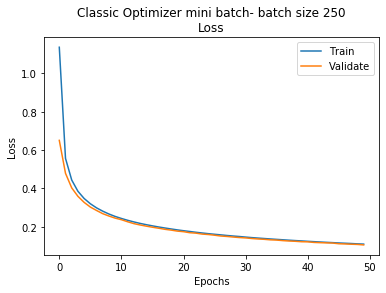

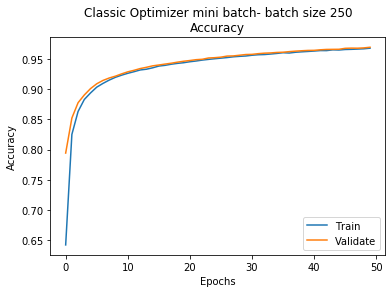

Accuracy on Test Data:0.9498


In [14]:
plot_fit_res(res_base,'Classic Optimizer mini batch- batch size 250')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_base))

In [15]:
adam_optimizer = AdamOptimizer(50,None,1e-3,0.9,0.999,1e-8)

nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
res_adam = nn_test.fit(train_data,val_data,adam_optimizer,250,True,True)
test_accuracy_adam = nn_test.predict(test_data)[2]

Fit time for Adam Optimizer mini batch- batch size 250 is 428s


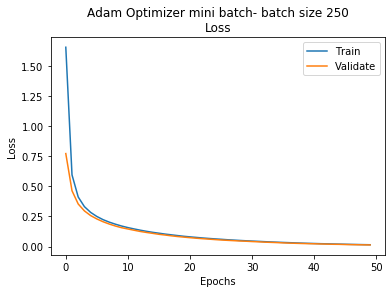

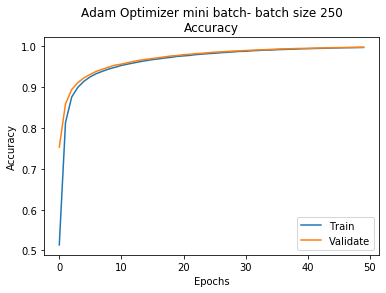

Accuracy on Test Data:0.9616


In [16]:
plot_fit_res(res_adam,'Adam Optimizer mini batch- batch size 250')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_adam))

In [17]:
#compare the effect of batch size on the model

In [18]:
optimizer = Optimizer(50,None,1e-3)
nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
res_largebatch = nn_test.fit(train_data,val_data,optimizer,2500,True,True)
test_accuracy_lb = nn_test.predict(test_data)[2]

Fit time for Classic Optimizer mini batch- batch size 2500 is 395s


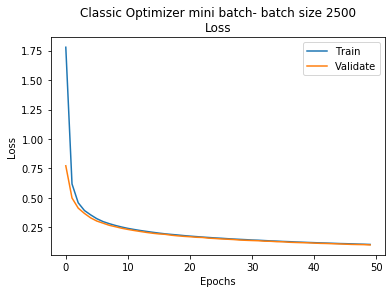

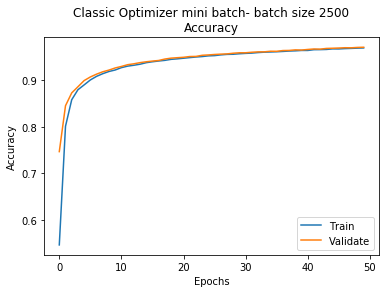

Accuracy on Test Data:0.9487


In [19]:
plot_fit_res(res_largebatch,'Classic Optimizer mini batch- batch size 2500')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_lb))

In [20]:
optimizer = Optimizer(50,None,1e-3)
nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
res_fullbatch = nn_test.fit(train_data,val_data,optimizer,None,False,True)
test_accuracy_fb = nn_test.predict(test_data)[2]

Fit time for Classic Optimizer full batch is 267s


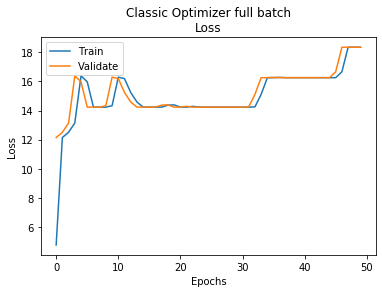

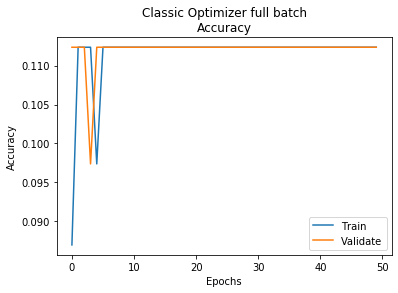

Accuracy on Test Data:0.1135


In [21]:
plot_fit_res(res_fullbatch,'Classic Optimizer full batch')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_fb))

In [22]:
#compare the effect of shuffling

In [23]:
optimizer = Optimizer(50,None,1e-3)
nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
res_shuffling = nn_test.fit(train_data,val_data,optimizer,250,False,True)
test_accuracy_shufl = nn_test.predict(test_data)[2]

Fit time for Classic Optimizer mini batch- batch size 250 with no shuffling is 389s


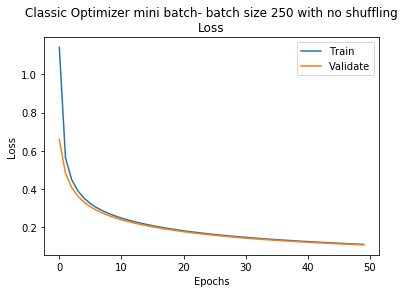

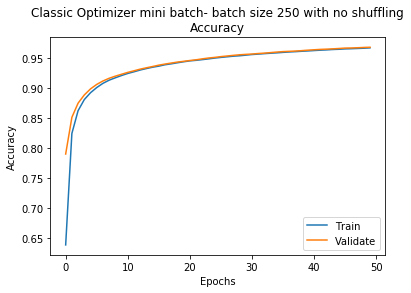

Accuracy on Test Data:0.9478


In [24]:
plot_fit_res(res_shuffling,'Classic Optimizer mini batch- batch size 250 with no shuffling')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_shufl))

In [26]:
summary_loss={'Parameters':['Base','Adam','Large Batch','Full Batch','No Shuffling'],
              'train':[res_base['loss']['train'][-1],res_adam['loss']['train'][-1],
                       res_largebatch['loss']['train'][-1],res_fullbatch['loss']['train'][-1],
                       res_shuffling['loss']['train'][-1]],
              'validate':[res_base['loss']['validate'][-1],res_adam['loss']['validate'][-1],
                       res_largebatch['loss']['validate'][-1],res_fullbatch['loss']['validate'][-1],
                       res_shuffling['loss']['validate'][-1]]}

summary_acc={'test':['Base','Adam','Large Batch','Full Batch','No Shuffling'],
              'train':[res_base['Accuracy']['train'][-1],res_adam['Accuracy']['train'][-1],
                       res_largebatch['Accuracy']['train'][-1],res_fullbatch['Accuracy']['train'][-1],
                       res_shuffling['Accuracy']['train'][-1]],
              'validate':[res_base['Accuracy']['validate'][-1],res_adam['Accuracy']['validate'][-1],
                       res_largebatch['Accuracy']['validate'][-1],res_fullbatch['Accuracy']['validate'][-1],
                       res_shuffling['Accuracy']['validate'][-1]],
            'test':[test_accuracy_base,test_accuracy_adam,test_accuracy_lb,test_accuracy_fb,test_accuracy_shufl]}

summary_loss_df = pd.DataFrame(summary_loss)
summary_acc_df  = pd.DataFrame(summary_acc)
summary = pd.concat([summary_loss_df[['Parameters']],summary_loss_df[['train','validate']],summary_acc_df[['train','validate','test']]],
                    keys=['','Loss', 'Accuracy'], axis=1)
summary

Loss             Accuracy                  
     Parameters      train   validate     train  validate    test
0          Base   0.110325   0.106109  0.967417  0.969000  0.9498
1          Adam   0.014886   0.013489  0.997617  0.998117  0.9616
2   Large Batch   0.105105   0.101141  0.969250  0.970733  0.9487
3    Full Batch  18.341939  18.341939  0.112367  0.112367  0.1135
4  No Shuffling   0.110043   0.107350  0.967433  0.968467  0.9478

In [ ]:
# we choose Adam with small size batch and suffling in the following tests
# we first start by testing the impact of the adam parameters on the quality of the optimization

In [27]:
beta1 = [0.7,0.8,0.9]
beta2  = [0.8,0.9,0.999]
res_index = {'beta 1':[],'beta 2':[]}
res_loss  = {'train':[],'validate':[]}
res_acc   = {'train':[],'validate':[]}
df_list = []
betas = []
for b1,b2 in list(itertools.product(beta1,beta2)):
    adam_optimizer = AdamOptimizer(50,None,1e-3,b1,b2,1e-8)
    nn_test = NeuralNetwork(784,[64,64],['ReLu','Sigmoid'],10,'SoftMax')
    #full results
    res = nn_test.fit(train_data,val_data,adam_optimizer,250,False,True)
    res_df = pd.concat([pd.DataFrame(res['loss']),pd.DataFrame(res['Accuracy'])],
                       keys=['loss','Accuracy'], axis=1)
    
    df_list.append(res_df)
    betas.append(str((b1,b2)))
    
    #summary
    res_index['beta 1'].append(b1)
    res_index['beta 2'].append(b2)
    
    res_loss['train'].append(res['loss']['train'][-1])
    res_loss['validate'].append(res['loss']['validate'][-1])
    
    res_acc['train'].append(res['Accuracy']['train'][-1])
    res_acc['validate'].append(res['Accuracy']['validate'][-1])
    
full_res = pd.concat(df_list,keys=betas, axis=1)
full_res.to_csv('Adam betas.csv')

summary_res = pd.concat([pd.DataFrame(res_index),pd.DataFrame(res_loss),pd.DataFrame(res_acc)],
         keys=['betas','Loss','Accuracy'],axis=1)

In [28]:
summary_res

betas             Loss            Accuracy          
  beta 1 beta 2     train  validate     train  validate
0    0.7  0.800  0.025193  0.025840  0.994450  0.993733
1    0.7  0.900  0.020934  0.022159  0.995683  0.994950
2    0.7  0.999  0.017026  0.017022  0.997067  0.996900
3    0.8  0.800  0.019976  0.020382  0.995550  0.994917
4    0.8  0.900  0.019486  0.019526  0.995950  0.995467
5    0.8  0.999  0.015572  0.016057  0.997600  0.996983
6    0.9  0.800  0.010484  0.016133  0.998133  0.995367
7    0.9  0.900  0.015545  0.018640  0.996967  0.995333
8    0.9  0.999  0.016650  0.018062  0.997283  0.996433

##### Testing different architectures of our neural network, at a lower size <64 neurons and max epoch of 25


In [241]:
n_neurones  = [8,16,32,64]
activations = ['ReLu','Sigmoid','ReLu_Sigmoid','Sigmoid_ReLu','ReLu_ReLu','Sigmoid_Sigmoid']
nn_list = {}
performance=[]
#create parameters for neural network to use
for f in activations:
    if(len(f.split("_"))==1):
        for neurones in n_neurones:
            nn_list[f+"_"+str(neurones)]=[[f],[neurones]]
    else:
        for neurones in list(itertools.combinations(n_neurones,2)):
            nn_list[f+","+str(neurones[1])+"_"+str(neurones[0])]=[f.split("_"),[neurones[1],neurones[0]]]

res2_loss  = {'train':[],'validate':[]}
res2_acc   = {'train':[],'validate':[],'test':[]}
df2_list = []
for nn_param in nn_list.keys():
    nn_test = NeuralNetwork(784,nn_list[nn_param][1],nn_list[nn_param][0],10,'SoftMax')
    adam_optimizer = AdamOptimizer(25,None,1e-3,0.9,0.999,1e-8)
    res = nn_test.fit(train_data,val_data,adam_optimizer,250,False,True)
    
    res_df = pd.concat([pd.DataFrame(res['loss']),pd.DataFrame(res['Accuracy'])],
                       keys=['loss','Accuracy'], axis=1)
    test_accuracy = nn_test.predict(test_data)[2]
    
    df2_list.append(res_df)
    performance.append(res['fit time'])
    #summary

    res2_loss['train'].append(res['loss']['train'][-1])
    res2_loss['validate'].append(res['loss']['validate'][-1])
    
    res2_acc['train'].append(res['Accuracy']['train'][-1])
    res2_acc['validate'].append(res['Accuracy']['validate'][-1])
    res2_acc['test'].append(test_accuracy)
    
full_res0 = pd.concat(df2_list,keys=nn_list.keys(), axis=1)
full_res0.to_csv('NN Architecture.csv')

summary_res = pd.concat([pd.DataFrame(nn_list.keys()),pd.DataFrame(res2_loss),pd.DataFrame(res2_acc)],
         keys=['NeuralNetwork','Loss','Accuracy'],axis=1)

In [242]:
summary_res.to_csv("Summary NN Architecture.csv")
summary_res

NeuralNetwork      Loss            Accuracy                  
                        0     train  validate     train  validate    test
0                  ReLu_8  0.298765  0.293707  0.910367  0.911867  0.9126
1                 ReLu_16  0.203889  0.198330  0.939467  0.941850  0.9362
2                 ReLu_32  0.142580  0.137445  0.959083  0.960617  0.9475
3                 ReLu_64  0.107068  0.100394  0.968350  0.970683  0.9529
4               Sigmoid_8  0.354173  0.349205  0.898867  0.900883  0.9020
5              Sigmoid_16  0.216267  0.211568  0.938783  0.940133  0.9326
6              Sigmoid_32  0.134253  0.129364  0.961250  0.962967  0.9498
7              Sigmoid_64  0.093876  0.088805  0.974500  0.976183  0.9570
8       ReLu_Sigmoid,16_8  0.229361  0.223352  0.939917  0.942100  0.9300
9       ReLu_Sigmoid,32_8  0.162816  0.158888  0.958950  0.959350  0.9434
10      ReLu_Sigmoid,64_8  0.111903  0.108043  0.972450  0.973667  0.9540
11     ReLu_Sigmoid,32_16  0.129573  0.125277  0.962950  0.964150  0.9480
12     ReLu_Sigmoid,64_16  0.094912  0.090700  0.974467  0.975167  0.9541
13     ReLu_Sigmoid,64_32  0.090907  0.089740  0.975750  0.974933  0.9534
14      Sigmoid_ReLu,16_8  0.215983  0.210625  0.939667  0.942000  0.9343
15      Sigmoid_ReLu,32_8  0.131822  0.126556  0.962767  0.964150  0.9435
16      Sigmoid_ReLu,64_8  0.080602  0.075009  0.978267  0.980067  0.9556
17     Sigmoid_ReLu,32_16  0.117283  0.111407  0.965933  0.967567  0.9513
18     Sigmoid_ReLu,64_16  0.075324  0.069988  0.979267  0.980483  0.9567
19     Sigmoid_ReLu,64_32  0.061539  0.057321  0.983500  0.984900  0.9616
20         ReLu_ReLu,16_8  0.244430  0.237305  0.927900  0.930867  0.9262
21         ReLu_ReLu,32_8  0.177830  0.171185  0.949767  0.951100  0.9423
22         ReLu_ReLu,64_8  1.754137  1.885959  0.821417  0.828900  0.8290
23        ReLu_ReLu,32_16  0.196561  0.188515  0.942583  0.944917  0.9329
24        ReLu_ReLu,64_16  0.138132  0.129242  0.960850  0.963283  0.9436
25        ReLu_ReLu,64_32  0.159203  0.151066  0.953767  0.955600  0.9380
26   Sigmoid_Sigmoid,16_8  0.270554  0.264505  0.928433  0.929850  0.9286
27   Sigmoid_Sigmoid,32_8  0.150498  0.145192  0.959150  0.960833  0.9445
28   Sigmoid_Sigmoid,64_8  0.099794  0.094449  0.975700  0.977233  0.9562
29  Sigmoid_Sigmoid,32_16  0.133509  0.128575  0.962617  0.964050  0.9477
30  Sigmoid_Sigmoid,64_16  0.080413  0.076262  0.979017  0.979933  0.9602
31  Sigmoid_Sigmoid,64_32  0.068968  0.066490  0.981750  0.981967  0.9603

#### Comparing different architectures in term of the impact of adding neurons, layers and the choice of activation function:

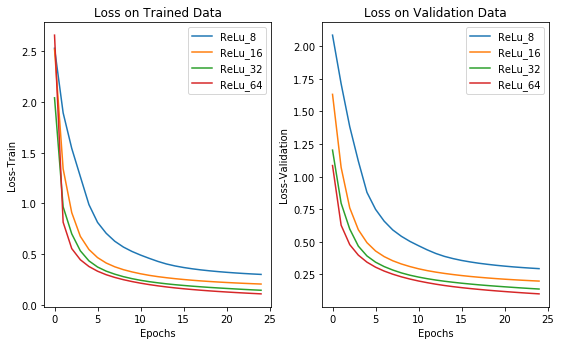

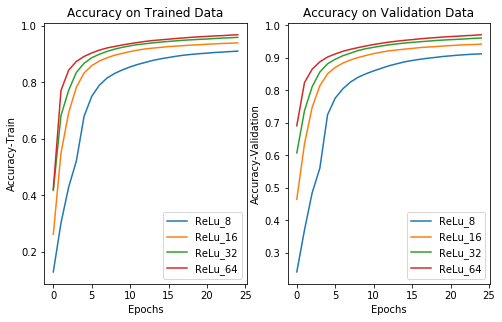

,NeuralNetwork,Accuracy
,0,test
0,ReLu_8,0.9126
1,ReLu_16,0.9362
2,ReLu_32,0.9475
3,ReLu_64,0.9529


In [256]:
#compare single ReLu layer with different numbers of neurons
fig,fig1=plot_nn_comparison(full_res0,['ReLu_8','ReLu_16','ReLu_32','ReLu_64'])
fig.savefig(os.path.join(path,"One HL ReLu,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"One HL ReLu,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['ReLu_8','ReLu_16','ReLu_32','ReLu_64'])]

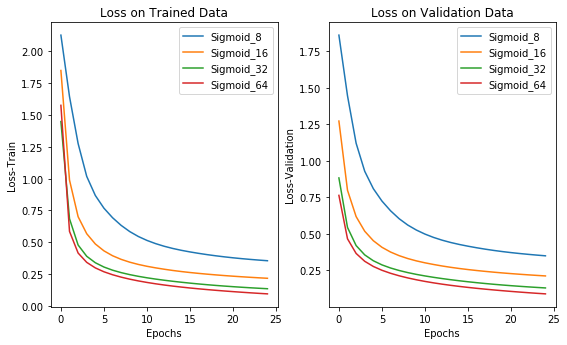

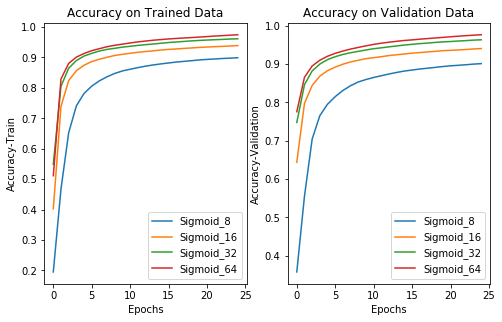

,NeuralNetwork,Accuracy
,0,test
4,Sigmoid_8,0.9020
5,Sigmoid_16,0.9326
6,Sigmoid_32,0.9498
7,Sigmoid_64,0.9570


In [255]:
#compare single ReLu layer with different numbers of neurons
fig,fig1=plot_nn_comparison(full_res0,['Sigmoid_8','Sigmoid_16','Sigmoid_32','Sigmoid_64'])
fig.savefig(os.path.join(path,"One HL Sigmoid,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"One HL Sigmoid,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['Sigmoid_8','Sigmoid_16','Sigmoid_32','Sigmoid_64'])]

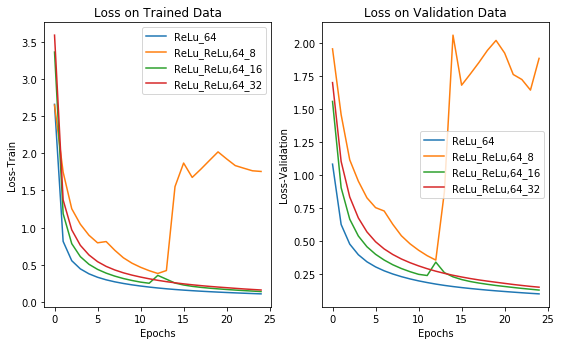

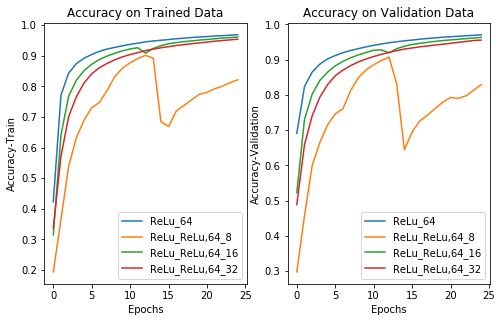

,NeuralNetwork,Accuracy
,0,test
3,ReLu_64,0.9529
22,"ReLu_ReLu,64_8",0.8290
24,"ReLu_ReLu,64_16",0.9436
25,"ReLu_ReLu,64_32",0.9380


In [253]:
fig,fig1=plot_nn_comparison(full_res0,['ReLu_64','ReLu_ReLu,64_8','ReLu_ReLu,64_16','ReLu_ReLu,64_32'])
fig.savefig(os.path.join(path,"Two HL ReLu64-ReLu,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two HL ReLu64-ReLu,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['ReLu_64','ReLu_ReLu,64_8','ReLu_ReLu,64_16','ReLu_ReLu,64_32'])]

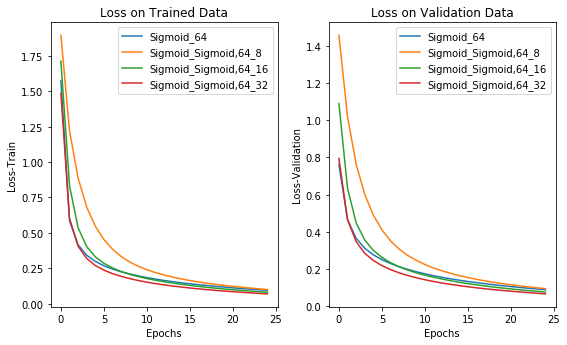

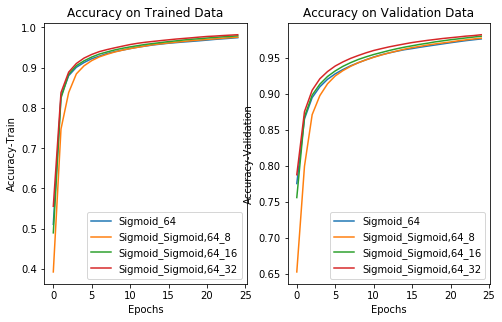

,NeuralNetwork,Accuracy
,0,test
7,Sigmoid_64,0.9570
28,"Sigmoid_Sigmoid,64_8",0.9562
30,"Sigmoid_Sigmoid,64_16",0.9602
31,"Sigmoid_Sigmoid,64_32",0.9603


In [252]:
fig,fig1=plot_nn_comparison(full_res0,['Sigmoid_64','Sigmoid_Sigmoid,64_8','Sigmoid_Sigmoid,64_16','Sigmoid_Sigmoid,64_32'])
fig.savefig(os.path.join(path,"Two HL Sig64-Sig,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two HL Sig64-Sig,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['Sigmoid_64','Sigmoid_Sigmoid,64_8','Sigmoid_Sigmoid,64_16',
                                           'Sigmoid_Sigmoid,64_32'])]

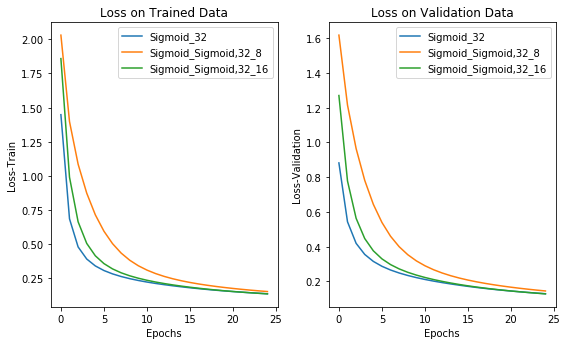

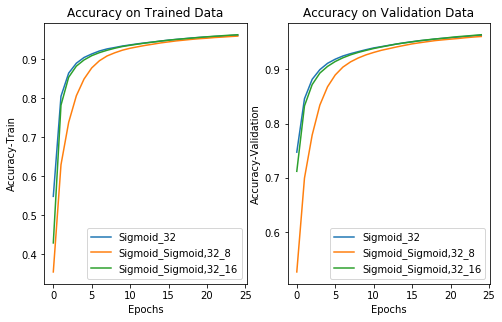

,NeuralNetwork,Accuracy
,0,test
6,Sigmoid_32,0.9498
27,"Sigmoid_Sigmoid,32_8",0.9445
29,"Sigmoid_Sigmoid,32_16",0.9477


In [251]:
fig,fig1=plot_nn_comparison(full_res0,['Sigmoid_32','Sigmoid_Sigmoid,32_8','Sigmoid_Sigmoid,32_16'])

fig.savefig(os.path.join(path,"Two HL Sig-Sig,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two HL Sig-Sig,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['Sigmoid_32','Sigmoid_Sigmoid,32_8','Sigmoid_Sigmoid,32_16'])]

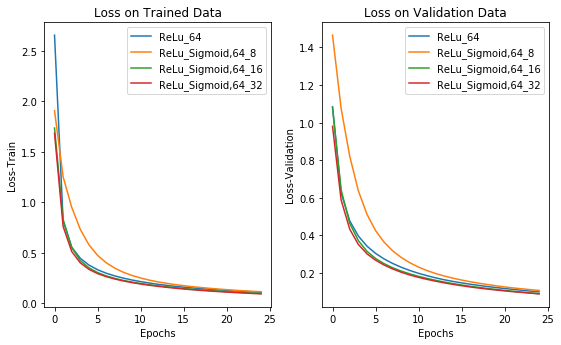

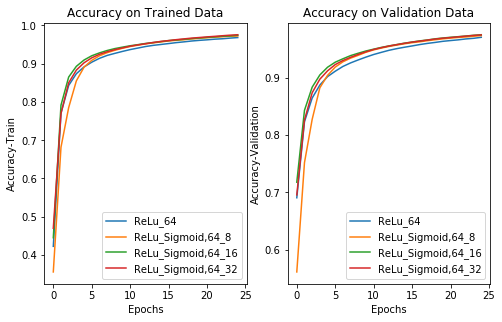

,NeuralNetwork,Accuracy
,0,test
3,ReLu_64,0.9529
10,"ReLu_Sigmoid,64_8",0.9540
12,"ReLu_Sigmoid,64_16",0.9541
13,"ReLu_Sigmoid,64_32",0.9534


In [249]:
fig,fig1=plot_nn_comparison(full_res0,['ReLu_64','ReLu_Sigmoid,64_8','ReLu_Sigmoid,64_16','ReLu_Sigmoid,64_32'])
fig.savefig(os.path.join(path,"Two HL ReLu-Sig,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two HL ReLu-Sig,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['ReLu_64','ReLu_Sigmoid,64_8','ReLu_Sigmoid,64_16','ReLu_Sigmoid,64_32'])]



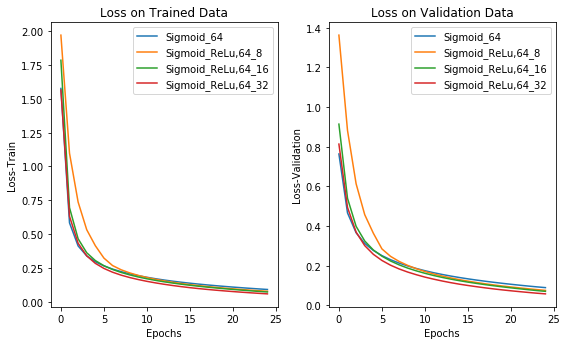

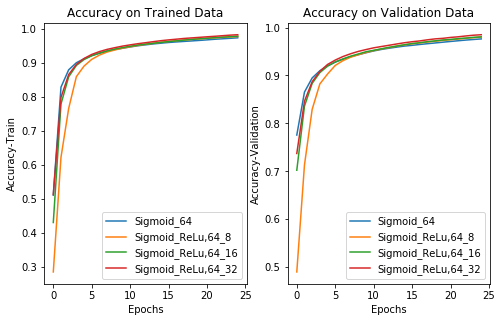

,NeuralNetwork,Accuracy
,0,test
7,Sigmoid_64,0.9570
16,"Sigmoid_ReLu,64_8",0.9556
18,"Sigmoid_ReLu,64_16",0.9567
19,"Sigmoid_ReLu,64_32",0.9616


In [250]:
fig,fig1=plot_nn_comparison(full_res0,['Sigmoid_64','Sigmoid_ReLu,64_8','Sigmoid_ReLu,64_16','Sigmoid_ReLu,64_32'])

fig.savefig(os.path.join(path,"Two HL Sig-ReLu,lowsize-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two HL Sig-ReLu,lowsize-Accuracy.jpg"))

summary_res[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res[('NeuralNetwork',0)].isin(['Sigmoid_64',
                                           'Sigmoid_ReLu,64_8','Sigmoid_ReLu,64_16','Sigmoid_ReLu,64_32'])]



#### Testing different architectures, in the below example we test large size architecture (size between 128-1024), and a max epoch of 10

In [175]:
n_neurones  = [128,256,512,1024]
activations = ['ReLu','Sigmoid','ReLu_Sigmoid','Sigmoid_ReLu','ReLu_ReLu','Sigmoid_Sigmoid']
nn_list = {}
performance3=[]
#create parameters for neural network to use
for f in activations:
    if(len(f.split("_"))==1):
        for neurones in n_neurones:
            nn_list[f+"_"+str(neurones)]=[[f],[neurones]]
    else:
        for neurones in list(itertools.combinations(n_neurones,2)):
            nn_list[f+","+str(neurones[1])+"_"+str(neurones[0])]=[f.split("_"),[neurones[1],neurones[0]]]

res2_loss  = {'train':[],'validate':[]}
res2_acc   = {'train':[],'validate':[],'test':[]}
df3_list = []
for nn_param in nn_list.keys():
    nn_test = NeuralNetwork(784,nn_list[nn_param][1],nn_list[nn_param][0],10,'SoftMax')
    adam_optimizer = AdamOptimizer(10,None,1e-3,0.9,0.999,1e-8)
    res = nn_test.fit(train_data,val_data,adam_optimizer,250,False,True)
    
    res_df = pd.concat([pd.DataFrame(res['loss']),pd.DataFrame(res['Accuracy'])],
                       keys=['loss','Accuracy'], axis=1)
    test_accuracy = nn_test.predict(test_data)[2]
    
    df3_list.append(res_df)
    performance3.append(res['fit time'])
    #summary

    res2_loss['train'].append(res['loss']['train'][-1])
    res2_loss['validate'].append(res['loss']['validate'][-1])
    
    res2_acc['train'].append(res['Accuracy']['train'][-1])
    res2_acc['validate'].append(res['Accuracy']['validate'][-1])
    res2_acc['test'].append(test_accuracy)
    
full_res = pd.concat(df3_list,keys=nn_list.keys(), axis=1)
full_res.to_csv('NN Architecture2.csv')

summary_res_3 = pd.concat([pd.DataFrame(nn_list.keys()),pd.DataFrame(res2_loss),pd.DataFrame(res2_acc)],
         keys=['NeuralNetwork','Loss','Accuracy'],axis=1)

In [177]:
summary_res_3.to_csv("Summary NN Architecture2.csv")
summary_res_3

NeuralNetwork      Loss            Accuracy                  
                           0     train  validate     train  validate    test
0                   ReLu_128  0.189524  0.172965  0.944750  0.949767  0.9322
1                   ReLu_256  0.140705  0.118816  0.968517  0.971300  0.9383
2                   ReLu_512  0.714630  0.706081  0.841800  0.839833  0.8333
3                  ReLu_1024  0.955874  0.947548  0.804900  0.805900  0.8062
4                Sigmoid_128  0.127635  0.117721  0.963717  0.967233  0.9520
5                Sigmoid_256  0.086490  0.075806  0.975867  0.980033  0.9585
6                Sigmoid_512  0.048184  0.040332  0.988517  0.990483  0.9582
7               Sigmoid_1024  0.021345  0.016075  0.996317  0.997550  0.9574
8       ReLu_Sigmoid,256_128  0.093336  0.088089  0.975917  0.976767  0.9381
9       ReLu_Sigmoid,512_128  0.070066  0.069358  0.983200  0.982100  0.9400
10     ReLu_Sigmoid,1024_128  0.058811  0.056106  0.985683  0.985700  0.9407
11      ReLu_Sigmoid,512_256  0.043534  0.043398  0.991517  0.990383  0.9366
12     ReLu_Sigmoid,1024_256  0.036892  0.039544  0.992950  0.991400  0.9392
13     ReLu_Sigmoid,1024_512  0.013450  0.013424  0.998333  0.998167  0.9320
14      Sigmoid_ReLu,256_128  0.088235  0.072738  0.975433  0.980600  0.9410
15      Sigmoid_ReLu,512_128  0.059080  0.050855  0.984567  0.986067  0.9428
16     Sigmoid_ReLu,1024_128  0.041572  0.036530  0.988533  0.989067  0.9455
17      Sigmoid_ReLu,512_256  0.035396  0.029686  0.992417  0.993200  0.9365
18     Sigmoid_ReLu,1024_256  0.033752  0.030278  0.991883  0.992067  0.9417
19     Sigmoid_ReLu,1024_512  0.594738  0.547881  0.882550  0.897233  0.8880
20         ReLu_ReLu,256_128  1.136328  1.128253  0.806900  0.811433  0.8159
21         ReLu_ReLu,512_128  0.953674  0.940758  0.847583  0.849083  0.8429
22        ReLu_ReLu,1024_128  1.041423  1.008870  0.846400  0.849250  0.8480
23         ReLu_ReLu,512_256  0.770352  0.752905  0.894317  0.896583  0.8909
24        ReLu_ReLu,1024_256  0.755090  0.736909  0.892783  0.895583  0.8900
25        ReLu_ReLu,1024_512  0.821106  0.801993  0.881483  0.885217  0.8799
26   Sigmoid_Sigmoid,256_128  0.060339  0.050488  0.984583  0.988367  0.9591
27   Sigmoid_Sigmoid,512_128  0.031523  0.024962  0.994800  0.996567  0.9644
28  Sigmoid_Sigmoid,1024_128  0.016257  0.014191  0.998500  0.998783  0.9644
29   Sigmoid_Sigmoid,512_256  0.021698  0.017660  0.997383  0.998017  0.9634
30  Sigmoid_Sigmoid,1024_256  0.009999  0.008662  0.999617  0.999767  0.9632
31  Sigmoid_Sigmoid,1024_512  0.005647  0.004784  0.999917  0.999933  0.9609

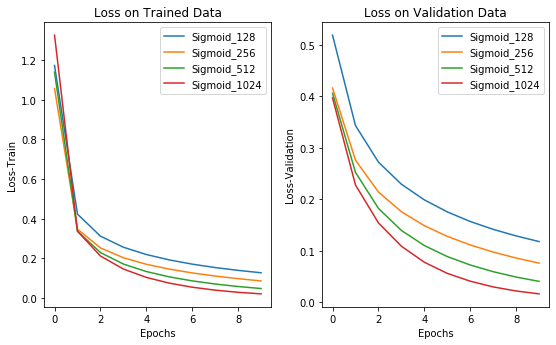

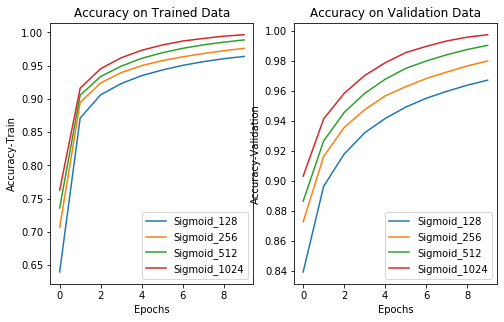

,NeuralNetwork,Accuracy
,0,test
4,Sigmoid_128,0.9520
5,Sigmoid_256,0.9585
6,Sigmoid_512,0.9582
7,Sigmoid_1024,0.9574


In [257]:
fig,fig1=plot_nn_comparison(full_res,['Sigmoid_128','Sigmoid_256','Sigmoid_512','Sigmoid_1024'])
fig.savefig(os.path.join(path,"One Sigmoid HL-Loss.jpg"))
fig1.savefig(os.path.join(path,"One Sigmoid HL-Accuracy.jpg"))

summary_res_3[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_3[('NeuralNetwork',0)].isin(['Sigmoid_128','Sigmoid_256','Sigmoid_512','Sigmoid_1024'])]



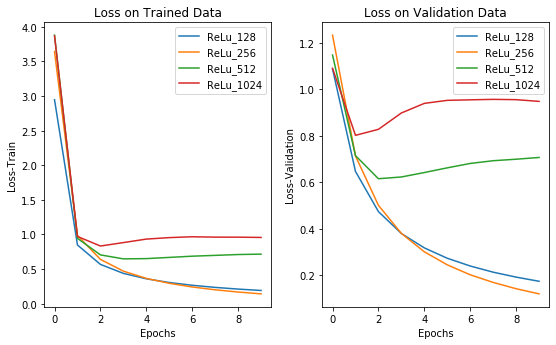

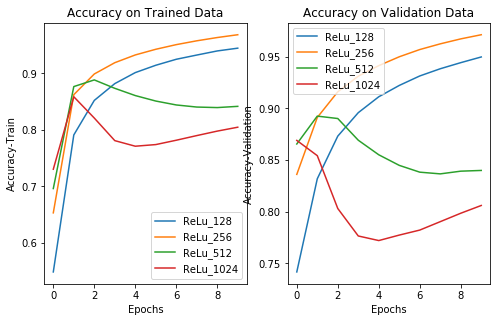

,NeuralNetwork,Accuracy
,0,test
0,ReLu_128,0.9322
1,ReLu_256,0.9383
2,ReLu_512,0.8333
3,ReLu_1024,0.8062


In [258]:
fig,fig1=plot_nn_comparison(full_res,['ReLu_128','ReLu_256','ReLu_512','ReLu_1024'])

fig.savefig(os.path.join(path,"One ReLu HL-Loss.jpg"))
fig1.savefig(os.path.join(path,"One ReLu HL-Accuracy.jpg"))

summary_res_3[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_3[('NeuralNetwork',0)].isin(['ReLu_128','ReLu_256','ReLu_512','ReLu_1024'])]


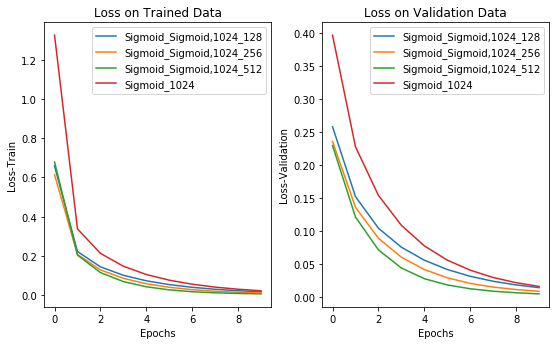

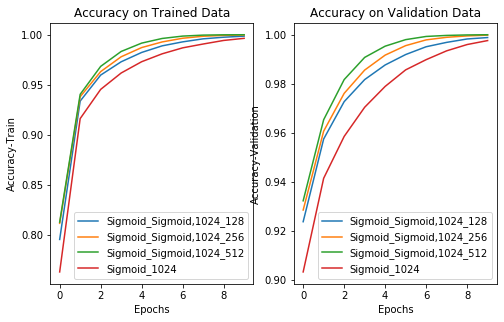

,NeuralNetwork,Accuracy
,0,test
7,Sigmoid_1024,0.9574
28,"Sigmoid_Sigmoid,1024_128",0.9644
30,"Sigmoid_Sigmoid,1024_256",0.9632
31,"Sigmoid_Sigmoid,1024_512",0.9609


In [259]:
fig,fig1=plot_nn_comparison(full_res,['Sigmoid_Sigmoid,1024_128','Sigmoid_Sigmoid,1024_256','Sigmoid_Sigmoid,1024_512',
                             'Sigmoid_1024'])

fig.savefig(os.path.join(path,"Two Sig HL based on Sig_1024-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two Sig HL based on Sig_1024-Accuracy.jpg"))

summary_res_3[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_3[('NeuralNetwork',0)].isin(['Sigmoid_Sigmoid,1024_128','Sigmoid_Sigmoid,1024_256','Sigmoid_Sigmoid,1024_512',
                             'Sigmoid_1024'])]



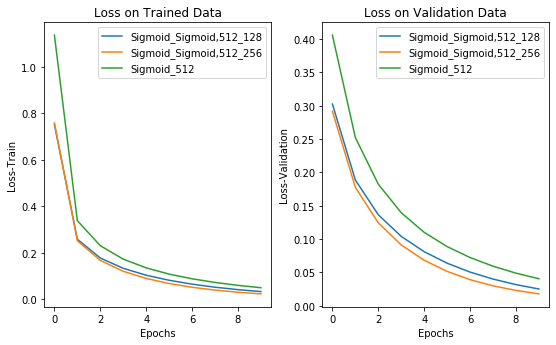

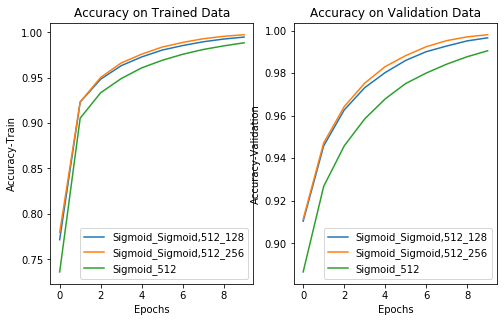

In [235]:
fig,fig1=plot_nn_comparison(full_res,['Sigmoid_Sigmoid,512_128','Sigmoid_Sigmoid,512_256','Sigmoid_512'])

summary_res_3[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_3[('NeuralNetwork',0)].isin(['Sigmoid_Sigmoid,512_128','Sigmoid_Sigmoid,512_256','Sigmoid_512'])]

fig.savefig(os.path.join(path,"Two Sig HL based on Sig_512-Loss.jpg"))
fig1.savefig(os.path.join(path,"Two Sig HL based on Sig_512-Accuracy.jpg"))

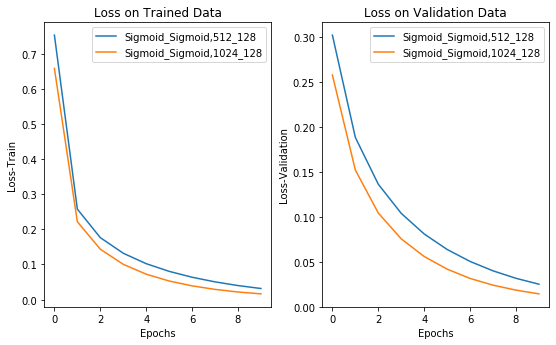

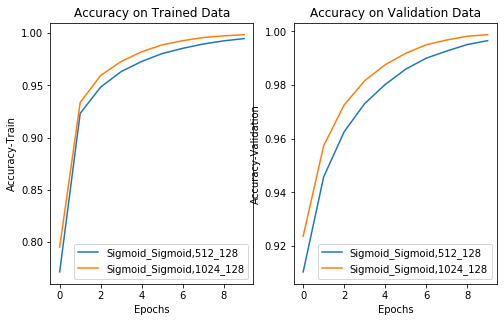

,NeuralNetwork,Accuracy
,0,test
27,"Sigmoid_Sigmoid,512_128",0.9644
28,"Sigmoid_Sigmoid,1024_128",0.9644


In [260]:
fig,fig1=plot_nn_comparison(full_res,['Sigmoid_Sigmoid,512_128','Sigmoid_Sigmoid,1024_128'])

fig.savefig(os.path.join(path,"Sig_Sig,512_128 vs Sig_Sig,1024_128-Loss.jpg"))
fig1.savefig(os.path.join(path,"Sig_Sig,512_128 vs Sig_Sig,1024_128-Accuracy.jpg"))

summary_res_3[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_3[('NeuralNetwork',0)].isin(['Sigmoid_Sigmoid,512_128','Sigmoid_Sigmoid,1024_128'])]



In [199]:
#we will investigate three layers on Sigmoid_Sigmoid,512_128

deep_nn_list={'Sig_Sig,512_128':[['Sigmoid', 'Sigmoid'], [512, 128]],
              'Sig_Sig_Sig,512_128_64':[['Sigmoid', 'Sigmoid','Sigmoid'], [512, 128,64]],
              'Sig_Sig_Sig,512_128_128':[['Sigmoid', 'Sigmoid','Sigmoid'], [512, 128,128]],
              'Sig_Sig_ReLu,512_128_64':[['Sigmoid', 'Sigmoid','ReLu'], [512, 128,64]],
              'Sig_Sig_ReLu,512_128_128':[['Sigmoid', 'Sigmoid','ReLu'], [512, 128,128]]}

res_deep_loss  = {'train':[],'validate':[]}
res_deep_acc   = {'train':[],'validate':[],'test':[]}
df_deep_list = []
performance_deep=[]
for nn_param in deep_nn_list.keys():
    nn_test = NeuralNetwork(784,deep_nn_list[nn_param][1],deep_nn_list[nn_param][0],10,'SoftMax')
    adam_optimizer = AdamOptimizer(10,None,1e-3,0.9,0.999,1e-8)
    res = nn_test.fit(train_data,val_data,adam_optimizer,250,False,True)
    
    res_df = pd.concat([pd.DataFrame(res['loss']),pd.DataFrame(res['Accuracy'])],
                       keys=['loss','Accuracy'], axis=1)
    test_accuracy = nn_test.predict(test_data)[2]
    
    df_deep_list.append(res_df)
    performance_deep.append(res['fit time'])
    #summary

    res_deep_loss['train'].append(res['loss']['train'][-1])
    res_deep_loss['validate'].append(res['loss']['validate'][-1])
    
    res_deep_acc['train'].append(res['Accuracy']['train'][-1])
    res_deep_acc['validate'].append(res['Accuracy']['validate'][-1])
    res_deep_acc['test'].append(test_accuracy)
    
full_deep_res = pd.concat(df_deep_list,keys=deep_nn_list.keys(), axis=1)
full_deep_res.to_csv('NN Architecture Deep.csv')

summary_res_deep = pd.concat([pd.DataFrame(deep_nn_list.keys()),pd.DataFrame(res_deep_loss),pd.DataFrame(res_deep_acc)],
         keys=['NeuralNetwork','Loss','Accuracy'],axis=1)

In [200]:
summary_res_deep.to_csv("Summary NN Architecture deep.csv")
summary_res_deep

NeuralNetwork      Loss            Accuracy                  
                          0     train  validate     train  validate    test
0           Sig_Sig,512_128  0.031523  0.024962  0.994800  0.996567  0.9644
1    Sig_Sig_Sig,512_128_64  0.024997  0.019965  0.995933  0.997333  0.9641
2   Sig_Sig_Sig,512_128_128  0.022433  0.017941  0.996683  0.997183  0.9629
3   Sig_Sig_ReLu,512_128_64  0.034633  0.028037  0.992917  0.994017  0.9496
4  Sig_Sig_ReLu,512_128_128  0.036307  0.032614  0.992800  0.993150  0.9459

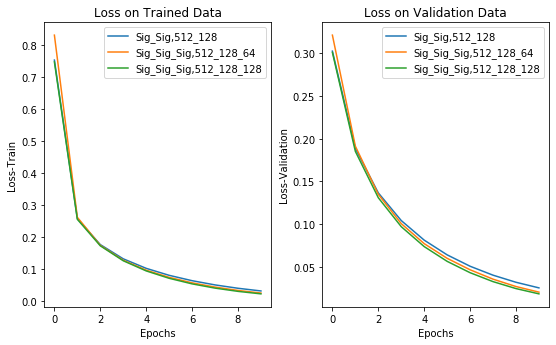

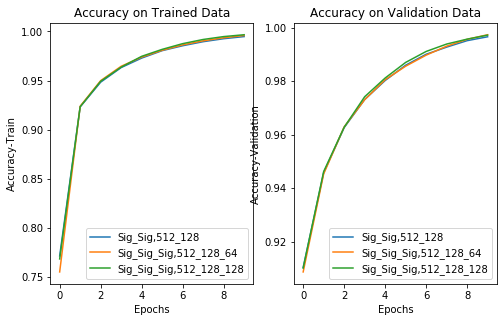

,NeuralNetwork,Accuracy
,0,test
0,"Sig_Sig,512_128",0.9644
1,"Sig_Sig_Sig,512_128_64",0.9641
2,"Sig_Sig_Sig,512_128_128",0.9629


In [261]:
fig,fig1=plot_nn_comparison(full_deep_res,['Sig_Sig,512_128','Sig_Sig_Sig,512_128_64','Sig_Sig_Sig,512_128_128'])

fig.savefig(os.path.join(path,"Three HL based on Sig_Sig,512_128-Loss.jpg"))
fig1.savefig(os.path.join(path,"Three HL based on Sig_Sig,512_128-Accuracy.jpg"))

summary_res_deep[[('NeuralNetwork',0),('Accuracy','test')]][
    summary_res_deep[('NeuralNetwork',0)].isin(['Sig_Sig,512_128','Sig_Sig_Sig,512_128_64',
                                                'Sig_Sig_Sig,512_128_128'])]


#### The below test allows us to investigate the impact of the batch size in the results of the network Sig_Sig,512_128

In [208]:
batch_sizes=[50,100,250,500]

res_batch_loss  = {'train':[],'validate':[]}
res_batch_acc   = {'train':[],'validate':[],'test':[]}
df_batch_list = []
performance_batch=[]
for b_size in batch_sizes:
    
    adam_optimizer = AdamOptimizer(10,None,1e-3,0.9,0.999,1e-8)

    nn_test = NeuralNetwork(784,[512,128],['Sigmoid','Sigmoid'],10,'SoftMax')
    res = nn_test.fit(train_data,val_data,adam_optimizer,b_size,True,True)
    res_df = pd.concat([pd.DataFrame(res['loss']),pd.DataFrame(res['Accuracy'])],
                       keys=['loss','Accuracy'], axis=1)
    test_accuracy = nn_test.predict(test_data)[2]
    
    df_batch_list.append(res_df)
    performance_batch.append(res['fit time'])
    #summary
    res_batch_loss['train'].append(res['loss']['train'][-1])
    res_batch_loss['validate'].append(res['loss']['validate'][-1])
    
    res_batch_acc['train'].append(res['Accuracy']['train'][-1])
    res_batch_acc['validate'].append(res['Accuracy']['validate'][-1])
    res_batch_acc['test'].append(test_accuracy)

full_batch_res = pd.concat(df_batch_list,keys=batch_sizes, axis=1)
full_batch_res.to_csv('NN Batches.csv')

summary_res_batch = pd.concat([pd.DataFrame(batch_sizes),pd.DataFrame(res_batch_loss),pd.DataFrame(res_batch_acc)],
         keys=['NeuralNetwork','Loss','Accuracy'],axis=1)

In [209]:
summary_res_batch.to_csv("Summary Batches.csv")
summary_res_batch

NeuralNetwork      Loss            Accuracy                  
              0     train  validate     train  validate    test
0            50  0.003363  0.003836  0.999817  0.999667  0.9705
1           100  0.007170  0.004774  0.999667  0.999950  0.9703
2           250  0.028717  0.022147  0.995817  0.997483  0.9641
3           500  0.060111  0.050229  0.986650  0.989833  0.9572

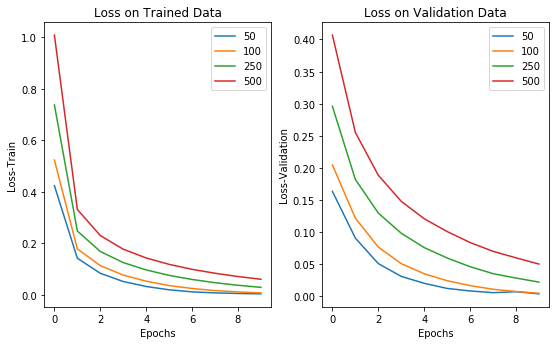

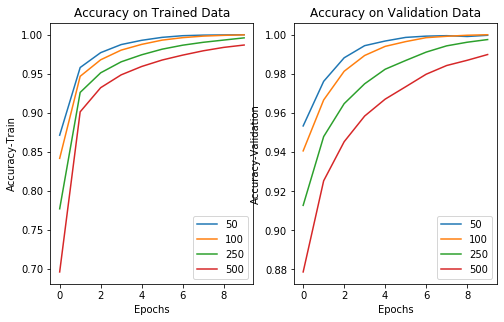

In [231]:
fig,fig1 = plot_nn_comparison(full_batch_res,batch_sizes)
fig.savefig(os.path.join(path,"Impact of Batch Size on Sig_Sig,512_128-Loss.jpg"))
fig1.savefig(os.path.join(path,"Impact of Batch Size on Sig_Sig,512_128-Accuracy.jpg"))

In [262]:
adam_optimizer = AdamOptimizer(10,None,1e-3,0.9,0.999,1e-8)

nn_test = NeuralNetwork(784,[512,128],['Sigmoid','ReLu'],10,'SoftMax')
res = nn_test.fit(train_data,val_data,adam_optimizer,100,True,True)

Fit time for Sigmoid_ReLu,512,128 is 521s


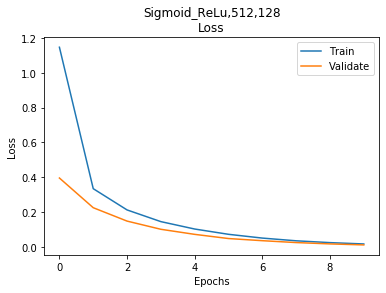

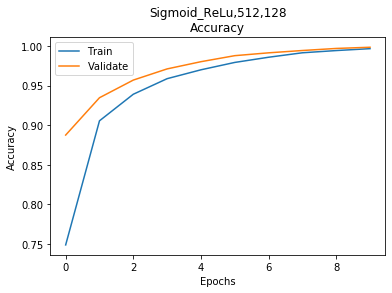

Accuracy on Test Data:0.9487


In [263]:
test_accuracy_sl = nn_test.predict(test_data)[2]
plot_fit_res(res,'Sigmoid_ReLu,512,128')
print("Accuracy on Test Data:{a}".format(a=test_accuracy_lb))